In [1]:
import numpy as np
import numpy.random as rnd
import theano
import theano.tensor as T
import lasagne
import time
import matplotlib.pyplot as plt
%matplotlib inline

CROSS VALIDATION FOR HYPERPARAMETERS

In [2]:
N_HIDDEN = 100
TRAIN_SIZE = int(1e5)
TEST_SIZE = int(1e4)
SEQ_LENS = [10, 50, 70, 100, 150, 200, 300, 400]

LEARNING_RATE = 0.001
GRAD_CLIP = 10
BATCH_SIZE = 20
NUM_EPOCHS = 10

In [3]:
def gen_add_data(length, n_batch=BATCH_SIZE):
    X = np.concatenate([np.random.uniform(size=(n_batch, length, 1)),
                        np.zeros((n_batch, length, 1))],
                        axis=-1)
    y = np.zeros((n_batch,))
    
    X[np.arange(n_batch), np.random.randint(length/10, size=n_batch), 1] = 1
    X[np.arange(n_batch), np.random.randint(length/2, length, size=n_batch), 1] = 1
    # Multiply and sum the dimensions of X to get the target value
    y = np.sum(X[:, :, 0] * X[:, :, 1], axis=1)
    
    return (X.astype(theano.config.floatX), y.astype(theano.config.floatX))

In [6]:
x, y = gen_add_data(10, 2)
y

array([ 1.47094693,  1.39937991])

In [4]:
train_data = {T : gen_add_data(T, TRAIN_SIZE) for T in SEQ_LENS}

In [5]:
for l in train_data:
    x = train_data[l][0]
    y = train_data[l][1]
    train_data[l] = {"x" : x, "y" : y}

In [6]:
test_data = {T : gen_add_data(T, TEST_SIZE) for T in SEQ_LENS}

In [7]:
for l in test_data:
    x = test_data[l][0]
    y = test_data[l][1]
    test_data[l] = {"x" : x, "y" : y}

In [10]:
# Use: train_data[seq_len]["x"/"y"][obj_idx]

В статье "Improving performance of RNN with ReLU" обучали на 10 эпох с BATCH_SIZE = 1.

В статье "Simple way to initialize RNN" до $8 * 10^6$ шагов с BATCH_SIZE = 16, причём лосс значительно менялся до $3 * 10^6$ шагов, что есть примерно 480 эпох.

In [8]:
# Вспомогательная функция для запаковки результата обучения 
def pack(network, inp, target, train_err, test_err, train_fn, test_fn):
    return {'network':network,
            'inp':inp,
            'target':target,
            
            'train_err':train_err,
            'test_err':test_err,
            'train_fn':train_fn, 
            'test_fn':test_fn
            } 

In [9]:
def init_posdef_w(n):
    # A = 1/N R^T * R, wehere R is standard normal
    # A is positive definite
    # W = (A + I) / max(spec(A + I))
    # spec(W) = {1, l_i < 1}
    
    R = np.random.normal(size=(n, n))
    A = 1 / N_HIDDEN * np.dot(R.T, R)
    eig, _ = np.linalg.eig(A + np.eye(n))
    e = max(eig)
    W = (A + np.eye(n)) / e
    return W

In [10]:
def build_network_np(inp, seq_len, num_epochs=NUM_EPOCHS):
    # Network from paper "Improving performance of RNN with ReLU"
    # W_hh is initialized as pos. def. with max eigenvalue 1
    
    l_in = lasagne.layers.InputLayer(shape=(None, seq_len, 2), input_var=inp)

    alpha = np.sqrt(2) * np.exp(1.2 / (max(N_HIDDEN, 6)))
    l_rnn = lasagne.layers.RecurrentLayer(
        l_in, N_HIDDEN,
        W_in_to_hid=lasagne.init.Normal(std=alpha / N_HIDDEN, mean=0.0),
        W_hid_to_hid=init_posdef_w(N_HIDDEN),
        learn_init=True,
        only_return_final=True,
        nonlinearity=lasagne.nonlinearities.rectify)

    l_out = lasagne.layers.DenseLayer(l_rnn, num_units=1,
                                      W=lasagne.init.GlorotNormal(),
                                      nonlinearity=lasagne.nonlinearities.linear)
    return l_out

In [11]:
def build_network_identity(inp, seq_len, num_epochs=NUM_EPOCHS):
    # Network from paper "Simple way to initialize RNN",
    # W_hh is initialized as identity matrix
    l_in = lasagne.layers.InputLayer(shape=(None, seq_len, 2), input_var=inp)

    l_rnn = lasagne.layers.RecurrentLayer(
        l_in, N_HIDDEN,
        W_in_to_hid=lasagne.init.Normal(1e-3, mean=0.0),
        W_hid_to_hid=np.eye(N_HIDDEN),
        learn_init=True,
        only_return_final=True,
        nonlinearity=lasagne.nonlinearities.rectify)
    
    l_out = lasagne.layers.DenseLayer(l_rnn, num_units=1,
                                      W=lasagne.init.GlorotNormal(),
                                      nonlinearity=lasagne.nonlinearities.linear)
    return l_out

In [12]:
def build_network_gaus(inp, seq_len, num_epochs=NUM_EPOCHS):
    # W_hh is initialized from standard normal
    l_in = lasagne.layers.InputLayer(shape=(None, seq_len, 2), input_var=inp)

    l_rnn = lasagne.layers.RecurrentLayer(
        l_in, N_HIDDEN,
        W_in_to_hid=lasagne.init.GlorotNormal(),
        W_hid_to_hid=lasagne.init.Normal(),
        learn_init=True,
        only_return_final=True,
        nonlinearity=lasagne.nonlinearities.rectify)
    
    l_out = lasagne.layers.DenseLayer(l_rnn, num_units=1,
                                      W=lasagne.init.GlorotNormal(),
                                      nonlinearity=lasagne.nonlinearities.linear)
    return l_out

In [13]:
# Create a network with particular initialization for parameters
def create_network(build_fn, seq_len):
    print("Building network ...")
    inp = T.tensor3('input', dtype='float64')
    # Matrix of size BATCH_SIZE * 1 to match network's output
    target_values = T.matrix('target_output', dtype='float64')
    network = build_fn(inp, seq_len)
    print("The network has {} params".format(lasagne.layers.count_params(network)))
    return (network, inp, target_values)

In [14]:
def train(network, inp, target_values, Xtrain, ytrain, Xtest, ytest, filename, num_epochs=NUM_EPOCHS):
    train_err = np.zeros(num_epochs)
    test_err = np.zeros(num_epochs)
    
    network_output = lasagne.layers.get_output(network)

    # Cost is MSE
    cost = T.mean((network_output - target_values)**2)
    all_params = lasagne.layers.get_all_params(network)
    print("Computing updates ...")
    all_grads = T.grad(cost, all_params)
    scaled_grads = lasagne.updates.total_norm_constraint(all_grads, GRAD_CLIP)
    updates = lasagne.updates.sgd(scaled_grads, all_params, LEARNING_RATE)
    
    print("Compiling functions ...")
    train_fn = theano.function([inp, target_values], cost, updates=updates, allow_input_downcast=True)
    compute_cost = theano.function([inp, target_values], cost, allow_input_downcast=True)
    
    num_batches = TRAIN_SIZE // BATCH_SIZE
    train_idxs = np.arange(TRAIN_SIZE)
    for epoch in range(num_epochs):
        start_time = time.time()
        np.random.shuffle(train_idxs)
        for batch in range(num_batches):
            idx = train_idxs[BATCH_SIZE * batch : BATCH_SIZE * (batch + 1)]
            train_err[epoch] += train_fn(Xtrain[idx, :, :], ytrain[idx, np.newaxis])
            
            if batch == num_batches // 4:
                print("Proc 25%", end="\t")
            if batch == num_batches // 2:
                print("Proc 50%", end="\t")
            if batch == num_batches // 4 * 3:
                print("Proc 75%")
                
        train_err[epoch] /= num_batches
        test_err[epoch] = compute_cost(Xtest, ytest[:, np.newaxis])
        print("Epoch {} test loss = {:.4f} \t train = {:.4f} \t time = {:.2f}s".format(
                epoch, test_err[epoch], train_err[epoch], time.time() - start_time), end="\t")
    np.save(file=filename, arr=lasagne.layers.get_all_param_values(network))
    return pack(network, inp, target_values, train_err, test_err, train_fn, compute_cost)

## Experiments

In [15]:
SEQ_LENS

[10, 50, 70, 100, 150, 200, 300, 400]

### Sequence length is 10

In [45]:
net, inp, tar = create_network(build_network_gaus, 10)
srnn10 = train(net, inp, tar, train_data[10]["x"], train_data[10]["y"],
                      test_data[10]["x"], test_data[10]["y"], "srnn10", num_epochs=10)

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Processed 25%
Processed 50%
Processed 75%
Epoch 0 test loss = 0.1522 	 train = 0.0085 	 time = 9.70s
Processed 25%
Processed 50%
Processed 75%
Epoch 1 test loss = 0.1438 	 train = 0.0073 	 time = 9.83s
Processed 25%
Processed 50%
Processed 75%
Epoch 2 test loss = 0.1317 	 train = 0.0068 	 time = 11.78s
Processed 25%
Processed 50%
Processed 75%
Epoch 3 test loss = 0.0977 	 train = 0.0059 	 time = 14.28s
Processed 25%
Processed 50%
Processed 75%
Epoch 4 test loss = 0.0029 	 train = 0.0011 	 time = 14.28s
Processed 25%
Processed 50%
Processed 75%
Epoch 5 test loss = 0.0019 	 train = 0.0001 	 time = 14.28s
Processed 25%
Processed 50%
Processed 75%
Epoch 6 test loss = 0.0013 	 train = 0.0001 	 time = 14.26s
Processed 25%
Processed 50%
Processed 75%
Epoch 7 test loss = 0.0010 	 train = 0.0001 	 time = 14.26s
Processed 25%
Processed 50%
Processed 75%
Epoch 8 test loss = 0.0008 	 train = 0.0000 	 ti

In [46]:
net, inp, tar = create_network(build_network_identity, 10)
irnn10 = train(net, inp, tar, train_data[10]["x"], train_data[10]["y"],
                      test_data[10]["x"], test_data[10]["y"], "irnn10", num_epochs=10)

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Processed 25%
Processed 50%
Processed 75%
Epoch 0 test loss = 0.0842 	 train = 0.0061 	 time = 9.70s
Processed 25%
Processed 50%
Processed 75%
Epoch 1 test loss = 0.0572 	 train = 0.0035 	 time = 10.11s
Processed 25%
Processed 50%
Processed 75%
Epoch 2 test loss = 0.0430 	 train = 0.0027 	 time = 13.70s
Processed 25%
Processed 50%
Processed 75%
Epoch 3 test loss = 0.0329 	 train = 0.0020 	 time = 12.45s
Processed 25%
Processed 50%
Processed 75%
Epoch 4 test loss = 0.0229 	 train = 0.0015 	 time = 10.28s
Processed 25%
Processed 50%
Processed 75%
Epoch 5 test loss = 0.0170 	 train = 0.0011 	 time = 14.14s
Processed 25%
Processed 50%
Processed 75%
Epoch 6 test loss = 0.0129 	 train = 0.0008 	 time = 14.46s
Processed 25%
Processed 50%
Processed 75%
Epoch 7 test loss = 0.0097 	 train = 0.0006 	 time = 10.20s
Processed 25%
Processed 50%
Processed 75%
Epoch 8 test loss = 0.0077 	 train = 0.0005 	 t

In [47]:
net, inp, tar = create_network(build_network_np, 10)
nprnn10 = train(net, inp, tar, train_data[10]["x"], train_data[10]["y"],
                      test_data[10]["x"], test_data[10]["y"], "nprnn10", num_epochs=10)

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Processed 25%
Processed 50%
Processed 75%
Epoch 0 test loss = 0.1176 	 train = 0.0073 	 time = 9.70s
Processed 25%
Processed 50%
Processed 75%
Epoch 1 test loss = 0.0645 	 train = 0.0045 	 time = 10.10s
Processed 25%
Processed 50%
Processed 75%
Epoch 2 test loss = 0.0500 	 train = 0.0028 	 time = 12.85s
Processed 25%
Processed 50%
Processed 75%
Epoch 3 test loss = 0.0319 	 train = 0.0018 	 time = 14.35s
Processed 25%
Processed 50%
Processed 75%
Epoch 4 test loss = 0.0135 	 train = 0.0010 	 time = 14.36s
Processed 25%
Processed 50%
Processed 75%
Epoch 5 test loss = 0.0080 	 train = 0.0005 	 time = 14.36s
Processed 25%
Processed 50%
Processed 75%
Epoch 6 test loss = 0.0051 	 train = 0.0003 	 time = 14.36s
Processed 25%
Processed 50%
Processed 75%
Epoch 7 test loss = 0.0035 	 train = 0.0002 	 time = 14.37s
Processed 25%
Processed 50%
Processed 75%
Epoch 8 test loss = 0.0025 	 train = 0.0002 	 t

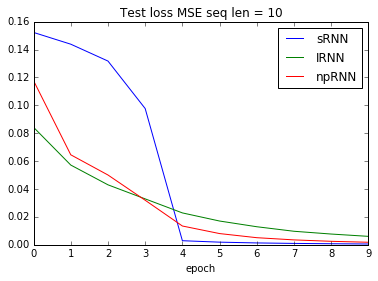

In [88]:
plt.figure(figsize=(6, 4))
plt.title("Test loss MSE seq len = 10")
plt.xlabel("epoch")
plt.plot(srnn10["test_err"], label="sRNN")
plt.plot(irnn10["test_err"], label="IRNN")
plt.plot(nprnn10["test_err"], label="npRNN")
plt.legend()

### Sequence length is 50

In [62]:
net, inp, tar = create_network(build_network_gaus, seq_len=50)
srnn50 = train(net, inp, tar, train_data[50]["x"], train_data[50]["y"],
                      test_data[50]["x"], test_data[50]["y"], "srnn50", num_epochs=10)

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Processed 25%
Processed 50%
Processed 75%
Epoch 0 test loss = 0.1680 	 train = 0.0094 	 time = 51.07s
Processed 25%
Processed 50%
Processed 75%
Epoch 1 test loss = 0.1667 	 train = 0.0083 	 time = 62.80s
Processed 25%
Processed 50%
Processed 75%
Epoch 2 test loss = 0.1664 	 train = 0.0083 	 time = 62.11s
Processed 25%
Processed 50%
Processed 75%
Epoch 3 test loss = 0.1662 	 train = 0.0082 	 time = 62.49s
Processed 25%
Processed 50%
Processed 75%
Epoch 4 test loss = 0.1657 	 train = 0.0082 	 time = 62.46s
Processed 25%
Processed 50%
Processed 75%
Epoch 5 test loss = 0.1655 	 train = 0.0082 	 time = 62.44s
Processed 25%
Processed 50%
Processed 75%
Epoch 6 test loss = 0.1652 	 train = 0.0082 	 time = 62.40s
Processed 25%
Processed 50%
Processed 75%
Epoch 7 test loss = 0.1649 	 train = 0.0082 	 time = 62.27s
Processed 25%
Processed 50%
Processed 75%
Epoch 8 test loss = 0.1648 	 train = 0.0082 	 

In [63]:
srnn50 = train(srnn50["network"], srnn50["inp"], srnn50["target"],
               train_data[50]["x"], train_data[50]["y"],
               test_data[50]["x"], test_data[50]["y"], "srnn50", num_epochs=20)

Computing updates ...
Compiling functions ...
Processed 25%
Processed 50%
Processed 75%
Epoch 0 test loss = 0.1639 	 train = 0.0081 	 time = 50.73s
Processed 25%
Processed 50%
Processed 75%
Epoch 1 test loss = 0.1637 	 train = 0.0081 	 time = 62.39s
Processed 25%
Processed 50%
Processed 75%
Epoch 2 test loss = 0.1630 	 train = 0.0081 	 time = 62.26s
Processed 25%
Processed 50%
Processed 75%
Epoch 3 test loss = 0.1626 	 train = 0.0081 	 time = 61.67s
Processed 25%
Processed 50%
Processed 75%
Epoch 4 test loss = 0.1620 	 train = 0.0081 	 time = 61.64s
Processed 25%
Processed 50%
Processed 75%
Epoch 5 test loss = 0.1614 	 train = 0.0080 	 time = 61.78s
Processed 25%
Processed 50%
Processed 75%
Epoch 6 test loss = 0.1606 	 train = 0.0080 	 time = 61.79s
Processed 25%
Processed 50%
Processed 75%
Epoch 7 test loss = 0.1595 	 train = 0.0079 	 time = 61.58s
Processed 25%
Processed 50%
Processed 75%
Epoch 8 test loss = 0.1578 	 train = 0.0079 	 time = 61.77s
Processed 25%
Processed 50%
Processe

In [67]:
net, inp, tar = create_network(build_network_identity, seq_len=50)
irnn50 = train(net, inp, tar, train_data[50]["x"], train_data[50]["y"],
                      test_data[50]["x"], test_data[50]["y"], "irnn50", num_epochs=30)

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Proc 25%	Proc 50%	Proc 75%
Epoch 0 test loss = 0.1626 	 train = 0.0084 	 time = 48.88s	Proc 25%	Proc 50%	Proc 75%
Epoch 1 test loss = 0.1631 	 train = 0.0080 	 time = 55.61s	Proc 25%	Proc 50%	Proc 75%
Epoch 2 test loss = 0.1373 	 train = 0.0075 	 time = 56.21s	Proc 25%	Proc 50%	Proc 75%
Epoch 3 test loss = 0.0896 	 train = 0.0062 	 time = 56.20s	Proc 25%	Proc 50%	Proc 75%
Epoch 4 test loss = 0.0621 	 train = 0.0045 	 time = 56.39s	Proc 25%	Proc 50%	Proc 75%
Epoch 5 test loss = 0.0353 	 train = 0.0029 	 time = 59.14s	Proc 25%	Proc 50%	Proc 75%
Epoch 6 test loss = 0.0232 	 train = 0.0017 	 time = 56.22s	Proc 25%	Proc 50%	Proc 75%
Epoch 7 test loss = 0.0169 	 train = 0.0011 	 time = 56.28s	Proc 25%	Proc 50%	Proc 75%
Epoch 8 test loss = 0.0150 	 train = 0.0008 	 time = 56.25s	Proc 25%	Proc 50%	Proc 75%
Epoch 9 test loss = 0.0088 	 train = 0.0006 	 time = 56.27s	Proc 25%	Proc 50%	Proc 75%
Epoch 1

In [68]:
net, inp, tar = create_network(build_network_np, seq_len=50)
nprnn50 = train(net, inp, tar, train_data[50]["x"], train_data[50]["y"],
                      test_data[50]["x"], test_data[50]["y"], "nprnn50", num_epochs=30)

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Proc 25%	Proc 50%	Proc 75%
Epoch 0 test loss = 0.1673 	 train = 0.0087 	 time = 47.93s	Proc 25%	Proc 50%	Proc 75%
Epoch 1 test loss = 0.1666 	 train = 0.0083 	 time = 55.20s	Proc 25%	Proc 50%	Proc 75%
Epoch 2 test loss = 0.1663 	 train = 0.0083 	 time = 55.21s	Proc 25%	Proc 50%	Proc 75%
Epoch 3 test loss = 0.1661 	 train = 0.0083 	 time = 55.13s	Proc 25%	Proc 50%	Proc 75%
Epoch 4 test loss = 0.1655 	 train = 0.0083 	 time = 57.97s	Proc 25%	Proc 50%	Proc 75%
Epoch 5 test loss = 0.1659 	 train = 0.0083 	 time = 55.22s	Proc 25%	Proc 50%	Proc 75%
Epoch 6 test loss = 0.1644 	 train = 0.0082 	 time = 58.27s	Proc 25%	Proc 50%	Proc 75%
Epoch 7 test loss = 0.1645 	 train = 0.0082 	 time = 55.54s	Proc 25%	Proc 50%	Proc 75%
Epoch 8 test loss = 0.1624 	 train = 0.0082 	 time = 58.65s	Proc 25%	Proc 50%	Proc 75%
Epoch 9 test loss = 0.1617 	 train = 0.0081 	 time = 58.61s	Proc 25%	Proc 50%	Proc 75%
Epoch 1

In [ ]:
[0.1680, 0.1667, 0.1664, 0.1662, 0.1657, 0.1655, 0.1652, 0.1649, 0.1648, 0.1643]

In [71]:
a = np.array([1, 2])
b = np.array([3, 4])
np.concatenate((a, b))

array([1, 2, 3, 4])

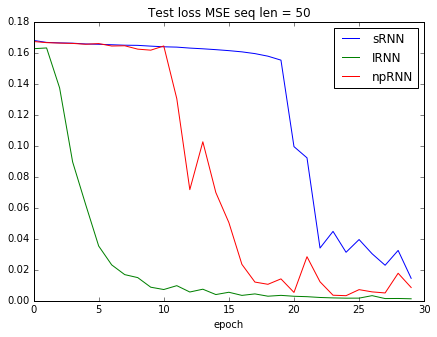

In [87]:
plt.figure(figsize=(7, 5))
plt.title("Test loss MSE seq len = 50")
plt.xlabel("epoch")
plt.plot(np.concatenate((np.array([0.1680, 0.1667, 0.1664, 0.1662, 0.1657,
                                  0.1655, 0.1652, 0.1649, 0.1648, 0.1643]), srnn50["test_err"])), label="sRNN")
plt.plot(irnn50["test_err"], label="IRNN")
plt.plot(nprnn50["test_err"], label="npRNN")
plt.legend()

### Sequence length is 70

In [74]:
net, inp, tar = create_network(build_network_gaus, seq_len=70)
srnn70 = train(net, inp, tar, train_data[70]["x"], train_data[70]["y"],
                      test_data[70]["x"], test_data[70]["y"], "srnn70", num_epochs=30)

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Proc 25%	Proc 50%	Proc 75%
Epoch 0 test loss = 0.1648 	 train = 0.0096 	 time = 76.23s	Proc 25%	Proc 50%	Proc 75%
Epoch 1 test loss = 0.1638 	 train = 0.0084 	 time = 80.73s	Proc 25%	Proc 50%	Proc 75%
Epoch 2 test loss = 0.1634 	 train = 0.0083 	 time = 77.50s	Proc 25%	Proc 50%	Proc 75%
Epoch 3 test loss = 0.1633 	 train = 0.0083 	 time = 80.31s	Proc 25%	Proc 50%	Proc 75%
Epoch 4 test loss = 0.1631 	 train = 0.0083 	 time = 77.75s	Proc 25%	Proc 50%	Proc 75%
Epoch 5 test loss = 0.1630 	 train = 0.0083 	 time = 78.32s	Proc 25%	Proc 50%	Proc 75%
Epoch 6 test loss = 0.1629 	 train = 0.0083 	 time = 77.56s	Proc 25%	Proc 50%	Proc 75%
Epoch 7 test loss = 0.1627 	 train = 0.0083 	 time = 81.42s	Proc 25%	Proc 50%	Proc 75%
Epoch 8 test loss = 0.1626 	 train = 0.0083 	 time = 80.68s	Proc 25%	Proc 50%	Proc 75%
Epoch 9 test loss = 0.1625 	 train = 0.0083 	 time = 77.34s	Proc 25%	Proc 50%	Proc 75%
Epoch 1

In [75]:
tmp_err = srnn70["test_err"]

In [76]:
srnn70 = train(srnn70["network"], srnn70["inp"], srnn70["target"],
               train_data[70]["x"], train_data[70]["y"],
               test_data[70]["x"], test_data[70]["y"], "srnn70", num_epochs=20)

Computing updates ...
Compiling functions ...
Proc 25%	Proc 50%	Proc 75%
Epoch 0 test loss = 0.1660 	 train = 0.0068 	 time = 69.95s	Proc 25%	Proc 50%	Proc 75%
Epoch 1 test loss = 0.0522 	 train = 0.0047 	 time = 77.62s	Proc 25%	Proc 50%	Proc 75%
Epoch 2 test loss = 0.0515 	 train = 0.0034 	 time = 78.06s	Proc 25%	Proc 50%	Proc 75%
Epoch 3 test loss = 0.0339 	 train = 0.0031 	 time = 78.69s	Proc 25%	Proc 50%	Proc 75%
Epoch 4 test loss = 0.0711 	 train = 0.0029 	 time = 77.86s	Proc 25%	Proc 50%	Proc 75%
Epoch 5 test loss = 0.0608 	 train = 0.0026 	 time = 80.67s	Proc 25%	Proc 50%	Proc 75%
Epoch 6 test loss = 0.0472 	 train = 0.0024 	 time = 78.49s	Proc 25%	Proc 50%	Proc 75%
Epoch 7 test loss = 0.0554 	 train = 0.0020 	 time = 78.44s	Proc 25%	Proc 50%	Proc 75%
Epoch 8 test loss = 0.0329 	 train = 0.0016 	 time = 81.11s	Proc 25%	Proc 50%	Proc 75%
Epoch 9 test loss = 0.0228 	 train = 0.0015 	 time = 78.59s	Proc 25%	Proc 50%	Proc 75%
Epoch 10 test loss = 0.0156 	 train = 0.0014 	 time = 82.

In [77]:
net, inp, tar = create_network(build_network_identity, seq_len=70)
irnn70 = train(net, inp, tar, train_data[70]["x"], train_data[70]["y"],
                      test_data[70]["x"], test_data[70]["y"], "irnn70", num_epochs=50)

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Proc 25%	Proc 50%	Proc 75%
Epoch 0 test loss = 0.1751 	 train = 0.0085 	 time = 71.15s	Proc 25%	Proc 50%	Proc 75%
Epoch 1 test loss = 0.1581 	 train = 0.0083 	 time = 78.08s	Proc 25%	Proc 50%	Proc 75%
Epoch 2 test loss = 0.1613 	 train = 0.0081 	 time = 78.55s	Proc 25%	Proc 50%	Proc 75%
Epoch 3 test loss = 0.1538 	 train = 0.0078 	 time = 78.82s	Proc 25%	Proc 50%	Proc 75%
Epoch 4 test loss = 0.1301 	 train = 0.0071 	 time = 78.52s	Proc 25%	Proc 50%	Proc 75%
Epoch 5 test loss = 0.1209 	 train = 0.0060 	 time = 78.65s	Proc 25%	Proc 50%	Proc 75%
Epoch 6 test loss = 0.0996 	 train = 0.0053 	 time = 78.41s	Proc 25%	Proc 50%	Proc 75%
Epoch 7 test loss = 0.0888 	 train = 0.0049 	 time = 78.09s	Proc 25%	Proc 50%	Proc 75%
Epoch 8 test loss = 0.0887 	 train = 0.0047 	 time = 78.65s	Proc 25%	Proc 50%	Proc 75%
Epoch 9 test loss = 0.0853 	 train = 0.0046 	 time = 79.31s	Proc 25%	Proc 50%	Proc 75%
Epoch 1

In [78]:
net, inp, tar = create_network(build_network_np, seq_len=70)
nprnn70 = train(net, inp, tar, train_data[70]["x"], train_data[70]["y"],
                      test_data[70]["x"], test_data[70]["y"], "nprnn70", num_epochs=50)

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Proc 25%	Proc 50%	Proc 75%
Epoch 0 test loss = 0.1644 	 train = 0.0088 	 time = 70.55s	Proc 25%	Proc 50%	Proc 75%
Epoch 1 test loss = 0.1648 	 train = 0.0083 	 time = 77.77s	Proc 25%	Proc 50%	Proc 75%
Epoch 2 test loss = 0.1638 	 train = 0.0083 	 time = 77.35s	Proc 25%	Proc 50%	Proc 75%
Epoch 3 test loss = 0.1654 	 train = 0.0083 	 time = 77.79s	Proc 25%	Proc 50%	Proc 75%
Epoch 4 test loss = 0.1637 	 train = 0.0083 	 time = 77.86s	Proc 25%	Proc 50%	Proc 75%
Epoch 5 test loss = 0.1636 	 train = 0.0083 	 time = 80.24s	Proc 25%	Proc 50%	Proc 75%
Epoch 6 test loss = 0.1634 	 train = 0.0083 	 time = 77.83s	Proc 25%	Proc 50%	Proc 75%
Epoch 7 test loss = 0.1636 	 train = 0.0083 	 time = 84.34s	Proc 25%	Proc 50%	Proc 75%
Epoch 8 test loss = 0.1640 	 train = 0.0083 	 time = 77.88s	Proc 25%	Proc 50%	Proc 75%
Epoch 9 test loss = 0.1640 	 train = 0.0083 	 time = 81.45s	Proc 25%	Proc 50%	Proc 75%
Epoch 1

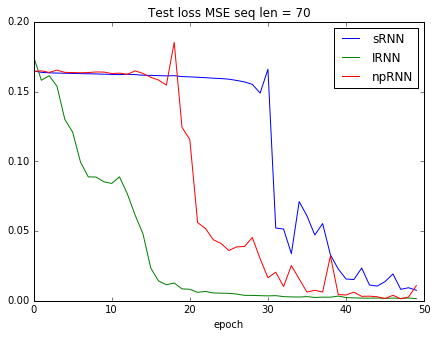

In [86]:
plt.figure(figsize=(7, 5))
plt.title("Test loss MSE seq len = 70")
plt.xlabel("epoch")
plt.plot(np.concatenate((tmp_err, srnn70["test_err"])), label="sRNN")
plt.plot(irnn70["test_err"], label="IRNN")
plt.plot(nprnn70["test_err"], label="npRNN")
plt.legend()

### Sequence length is 100

In [80]:
net, inp, tar = create_network(build_network_gaus, seq_len=100)
srnn100 = train(net, inp, tar, train_data[100]["x"], train_data[100]["y"],
                      test_data[100]["x"], test_data[100]["y"], "srnn100", num_epochs=50)

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Proc 25%	Proc 50%	Proc 75%
Epoch 0 test loss = 0.1647 	 train = 0.0096 	 time = 114.70s	Proc 25%	Proc 50%	Proc 75%
Epoch 1 test loss = 0.1640 	 train = 0.0084 	 time = 125.87s	Proc 25%	Proc 50%	Proc 75%
Epoch 2 test loss = 0.1638 	 train = 0.0084 	 time = 125.35s	Proc 25%	Proc 50%	Proc 75%
Epoch 3 test loss = 0.1637 	 train = 0.0083 	 time = 125.68s	Proc 25%	Proc 50%	Proc 75%
Epoch 4 test loss = 0.1635 	 train = 0.0083 	 time = 124.89s	Proc 25%	Proc 50%	Proc 75%
Epoch 5 test loss = 0.1634 	 train = 0.0083 	 time = 125.34s	Proc 25%	Proc 50%	Proc 75%
Epoch 6 test loss = 0.1634 	 train = 0.0083 	 time = 124.78s	Proc 25%	Proc 50%	Proc 75%
Epoch 7 test loss = 0.1633 	 train = 0.0083 	 time = 125.95s	Proc 25%	Proc 50%	Proc 75%
Epoch 8 test loss = 0.1631 	 train = 0.0083 	 time = 125.54s	Proc 25%	Proc 50%	Proc 75%
Epoch 9 test loss = 0.1631 	 train = 0.0083 	 time = 125.65s	Proc 25%	Proc 50%	Proc 7

In [83]:
net, inp, tar = create_network(build_network_identity, seq_len=100)
irnn100 = train(net, inp, tar, train_data[100]["x"], train_data[100]["y"],
                      test_data[100]["x"], test_data[100]["y"], "irnn100", num_epochs=50)

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Proc 25%	Proc 50%	Proc 75%
Epoch 0 test loss = 0.1636 	 train = 0.1704 	 time = 108.94s	Proc 25%	Proc 50%	Proc 75%
Epoch 1 test loss = 0.1627 	 train = 0.1681 	 time = 119.51s	Proc 25%	Proc 50%	Proc 75%
Epoch 2 test loss = 0.1583 	 train = 0.1662 	 time = 121.71s	Proc 25%	Proc 50%	Proc 75%
Epoch 3 test loss = 0.1562 	 train = 0.1634 	 time = 118.84s	Proc 25%	Proc 50%	Proc 75%
Epoch 4 test loss = 0.1537 	 train = 0.1609 	 time = 125.57s	Proc 25%	Proc 50%	Proc 75%
Epoch 5 test loss = 0.1284 	 train = 0.1541 	 time = 114.95s	Proc 25%	Proc 50%	Proc 75%
Epoch 6 test loss = 0.1116 	 train = 0.1237 	 time = 124.33s	Proc 25%	Proc 50%	Proc 75%
Epoch 7 test loss = 0.0442 	 train = 0.0867 	 time = 115.29s	Proc 25%	Proc 50%	Proc 75%
Epoch 8 test loss = 0.0219 	 train = 0.0330 	 time = 125.46s	Proc 25%	Proc 50%	Proc 75%
Epoch 9 test loss = 0.0306 	 train = 0.0143 	 time = 119.32s	Proc 25%	Proc 50%	Proc 7

In [84]:
net, inp, tar = create_network(build_network_np, seq_len=100)
nprnn100 = train(net, inp, tar, train_data[100]["x"], train_data[100]["y"],
                      test_data[100]["x"], test_data[100]["y"], "nprnn100", num_epochs=50)

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Proc 25%	Proc 50%	Proc 75%
Epoch 0 test loss = 0.1639 	 train = 0.1767 	 time = 106.27s	Proc 25%	Proc 50%	Proc 75%
Epoch 1 test loss = 0.1639 	 train = 0.1674 	 time = 130.86s	Proc 25%	Proc 50%	Proc 75%
Epoch 2 test loss = 0.1639 	 train = 0.1673 	 time = 139.61s	Proc 25%	Proc 50%	Proc 75%
Epoch 3 test loss = 0.1638 	 train = 0.1672 	 time = 132.15s	Proc 25%	Proc 50%	Proc 75%
Epoch 4 test loss = 0.1642 	 train = 0.1672 	 time = 129.40s	Proc 25%	Proc 50%	Proc 75%
Epoch 5 test loss = 0.1637 	 train = 0.1672 	 time = 130.73s	Proc 25%	Proc 50%	Proc 75%
Epoch 6 test loss = 0.1647 	 train = 0.1671 	 time = 116.48s	Proc 25%	Proc 50%	Proc 75%
Epoch 7 test loss = 0.1637 	 train = 0.1671 	 time = 127.13s	Proc 25%	Proc 50%	Proc 75%
Epoch 8 test loss = 0.1637 	 train = 0.1671 	 time = 122.70s	Proc 25%	Proc 50%	Proc 75%
Epoch 9 test loss = 0.1637 	 train = 0.1670 	 time = 129.24s	Proc 25%	Proc 50%	Proc 7

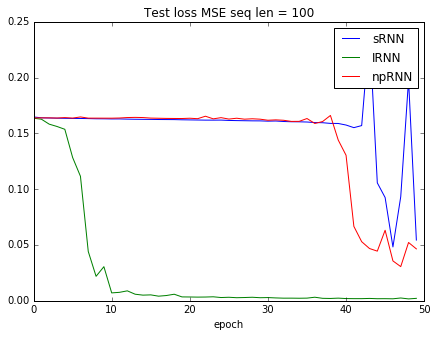

In [85]:
plt.figure(figsize=(7, 5))
plt.title("Test loss MSE seq len = 100")
plt.xlabel("epoch")
plt.plot(srnn100["test_err"], label="sRNN")
plt.plot(irnn100["test_err"], label="IRNN")
plt.plot(nprnn100["test_err"], label="npRNN")
plt.legend()

### Sequence length is 150

In [16]:
net, inp, tar = create_network(build_network_gaus, seq_len=150)
srnn150 = train(net, inp, tar, train_data[150]["x"], train_data[150]["y"],
                      test_data[150]["x"], test_data[150]["y"], "srnn150", num_epochs=80)

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Proc 25%	Proc 50%	Proc 75%
Epoch 0 test loss = 0.1681 	 train = 0.1914 	 time = 177.59s	Proc 25%	Proc 50%	Proc 75%
Epoch 1 test loss = 0.1658 	 train = 0.1666 	 time = 188.49s	Proc 25%	Proc 50%	Proc 75%
Epoch 2 test loss = 0.1653 	 train = 0.1657 	 time = 188.88s	Proc 25%	Proc 50%	Proc 75%
Epoch 3 test loss = 0.1652 	 train = 0.1655 	 time = 188.93s	Proc 25%	Proc 50%	Proc 75%
Epoch 4 test loss = 0.1651 	 train = 0.1654 	 time = 188.98s	Proc 25%	Proc 50%	Proc 75%
Epoch 5 test loss = 0.1650 	 train = 0.1653 	 time = 188.69s	Proc 25%	Proc 50%	Proc 75%
Epoch 6 test loss = 0.1649 	 train = 0.1652 	 time = 188.33s	Proc 25%	Proc 50%	Proc 75%
Epoch 7 test loss = 0.1649 	 train = 0.1652 	 time = 188.18s	Proc 25%	Proc 50%	Proc 75%
Epoch 8 test loss = 0.1649 	 train = 0.1651 	 time = 188.06s	Proc 25%	Proc 50%	Proc 75%
Epoch 9 test loss = 0.1649 	 train = 0.1651 	 time = 188.11s	Proc 25%	Proc 50%	Proc 7

In [17]:
net, inp, tar = create_network(build_network_identity, seq_len=150)
irnn150 = train(net, inp, tar, train_data[150]["x"], train_data[150]["y"],
                      test_data[150]["x"], test_data[150]["y"], "irnn150", num_epochs=80)

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Proc 25%	Proc 50%	Proc 75%
Epoch 0 test loss = 0.1660 	 train = 0.1702 	 time = 206.27s	Proc 25%	Proc 50%	Proc 75%
Epoch 1 test loss = 0.1669 	 train = 0.1663 	 time = 199.82s	Proc 25%	Proc 50%	Proc 75%
Epoch 2 test loss = 0.1659 	 train = 0.1664 	 time = 207.24s	Proc 25%	Proc 50%	Proc 75%
Epoch 3 test loss = 0.1654 	 train = 0.1667 	 time = 212.40s	Proc 25%	Proc 50%	Proc 75%
Epoch 4 test loss = 0.1671 	 train = 0.1665 	 time = 192.68s	Proc 25%	Proc 50%	Proc 75%
Epoch 5 test loss = 0.1637 	 train = 0.1661 	 time = 193.61s	Proc 25%	Proc 50%	Proc 75%
Epoch 6 test loss = 0.1655 	 train = 0.1656 	 time = 188.94s	Proc 25%	Proc 50%	Proc 75%
Epoch 7 test loss = 0.1665 	 train = 0.1640 	 time = 187.99s	Proc 25%	Proc 50%	Proc 75%
Epoch 8 test loss = 0.1642 	 train = 0.1626 	 time = 188.51s	Proc 25%	Proc 50%	Proc 75%
Epoch 9 test loss = 0.1611 	 train = 0.1624 	 time = 189.13s	Proc 25%	Proc 50%	Proc 7

In [19]:
net, inp, tar = create_network(build_network_np, seq_len=150)
nprnn150 = train(net, inp, tar, train_data[150]["x"], train_data[150]["y"],
                      test_data[150]["x"], test_data[150]["y"], "nprnn150", num_epochs=80)

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...
Proc 25%	Proc 50%	Proc 75%
Epoch 0 test loss = 0.1655 	 train = 0.1750 	 time = 177.96s	Proc 25%	Proc 50%	Proc 75%
Epoch 1 test loss = 0.1655 	 train = 0.1658 	 time = 188.91s	Proc 25%	Proc 50%	Proc 75%
Epoch 2 test loss = 0.1653 	 train = 0.1658 	 time = 187.42s	Proc 25%	Proc 50%	Proc 75%
Epoch 3 test loss = 0.1654 	 train = 0.1657 	 time = 187.09s	Proc 25%	Proc 50%	Proc 75%
Epoch 4 test loss = 0.1654 	 train = 0.1657 	 time = 187.16s	Proc 25%	Proc 50%	Proc 75%
Epoch 5 test loss = 0.1655 	 train = 0.1657 	 time = 188.27s	Proc 25%	Proc 50%	Proc 75%
Epoch 6 test loss = 0.1655 	 train = 0.1657 	 time = 188.30s	Proc 25%	Proc 50%	Proc 75%
Epoch 7 test loss = 0.1657 	 train = 0.1657 	 time = 188.32s	Proc 25%	Proc 50%	Proc 75%
Epoch 8 test loss = 0.1652 	 train = 0.1657 	 time = 188.02s	Proc 25%	Proc 50%	Proc 75%
Epoch 9 test loss = 0.1653 	 train = 0.1657 	 time = 187.97s	Proc 25%	Proc 50%	Proc 7

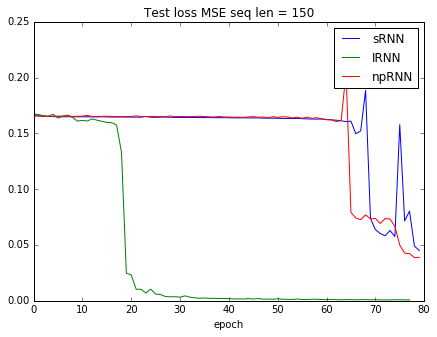

In [31]:
plt.figure(figsize=(7, 5))
plt.title("Test loss MSE seq len = 150")
plt.xlabel("epoch")
plt.plot(srnn150["test_err"], label="sRNN")
plt.plot(np.concatenate((irnn150["test_err"][:19], irnn150["test_err"][21:])), label="IRNN")
plt.plot(nprnn150["test_err"], label="npRNN")
plt.legend()

### Sequence length is 200

In [ ]:
net, inp, tar = create_network(build_network_gaus, seq_len=200)
srnn200 = train(net, inp, tar, train_data[200]["x"], train_data[200]["y"],
                      test_data[200]["x"], test_data[200]["y"], "srnn200", num_epochs=80)

Building network ...
The network has 10501 params
Computing updates ...
Compiling functions ...


In [141]:
def train(network, inp, target_values, Xtrain, ytrain, Xtest, ytest, filename, num_epochs=NUM_EPOCHS):
    train_err = np.zeros(num_epochs)
    test_err = np.zeros(num_epochs)
    
    network_output = lasagne.layers.get_output(network)

    # Cost is MSE
    cost = T.mean((network_output - target_values)**2)
    all_params = lasagne.layers.get_all_params(network)
    print("Computing updates ...")
    all_grads = T.grad(cost, all_params)
    scaled_grads = lasagne.updates.total_norm_constraint(all_grads, GRAD_CLIP)
    updates = lasagne.updates.adam(scaled_grads, all_params, LEARNING_RATE)
    
    print("Compiling functions ...")
    train_fn = theano.function([inp, target_values], cost, updates=updates, allow_input_downcast=True)
    compute_cost = theano.function([inp, target_values], cost, allow_input_downcast=True)
    
    num_batches = TRAIN_SIZE // BATCH_SIZE
    train_idxs = np.arange(TRAIN_SIZE)
    for epoch in range(num_epochs):
        start_time = time.time()
        np.random.shuffle(train_idxs)
        for batch in range(num_batches):
            idx = train_idxs[BATCH_SIZE * batch : BATCH_SIZE * (batch + 1)]
            train_err[epoch] += train_fn(Xtrain[idx, :, :], ytrain[idx, np.newaxis])
            
            if batch == num_batches // 4:
                print("Proc 25%", end="\t")
            if batch == num_batches // 2:
                print("Proc 50%", end="\t")
            if batch == num_batches // 4 * 3:
                print("Proc 75%")
                
        train_err[epoch] /= num_batches
        test_err[epoch] = compute_cost(Xtest, ytest[:, np.newaxis])
        print("Epoch {} test loss = {:.4f} \t train = {:.4f} \t time = {:.2f}s".format(
                epoch, test_err[epoch], train_err[epoch], time.time() - start_time), end="\t")
    np.save(file=filename, arr=lasagne.layers.get_all_param_values(network))
    return pack(network, inp, target_values, train_err, test_err, train_fn, compute_cost)